In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

from sklearn.feature_selection import RFE
from operator import itemgetter        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
The data has been collected by hand as it was formatted differently for nearly every row. Some points have been imputed by hand elsewhere, based off of photos, educated guesses and industry knowledge. Enough data has been collected so that feature engineering is now underway. One major point is how to encompass the information about number of doors and windows, experimenting with different ways of tackling these columns is currently underway. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or 2,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,0,2,2,...,2,1,2,2,1,2,2,2,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,0,2,2,...,2,1,2,2,0,2,2,2,0,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                      object
model                             object
total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
Usage Intent- On or 2              int64
A/C                                int64
Roof Rack                          int64
Driver Side Window                 int64
Driver Side Door                   int64
Driver Side Door Window            int64
Passenger Side Door                int64
Passenger Side Door Window         int64
Passenger Side Window              int64
Spare Tire                         int64
Battery Power Supply               int64
Cabinets                           int64
Refrigerator                       int64
Awning                             int64
Solar                              int64
STOVE                              int64
USB Charging                       int64
USB Cost        

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                     0
model                            5
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or 2            0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
USB Cost                         0
Base price                       0
dtype: int64

There are no missing values because the data has been imputed by hand beforehand. 

In [5]:
data.shape

(96, 26)

In [6]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"Usage Intent- On or 2": "Usage Intent- On or Off Road", "exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [7]:
#checking the categories are clean
data['Passenger Side Door Window'].value_counts()

2    71
1    19
0     6
Name: Passenger Side Door Window, dtype: int64

In [8]:
data.head(5)

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,0,2,2,...,2,1,2,2,1,2,2,2,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,0,2,2,...,2,1,2,2,1,2,2,2,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,0,2,2,...,2,1,2,2,0,2,2,2,0,18689


In [9]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

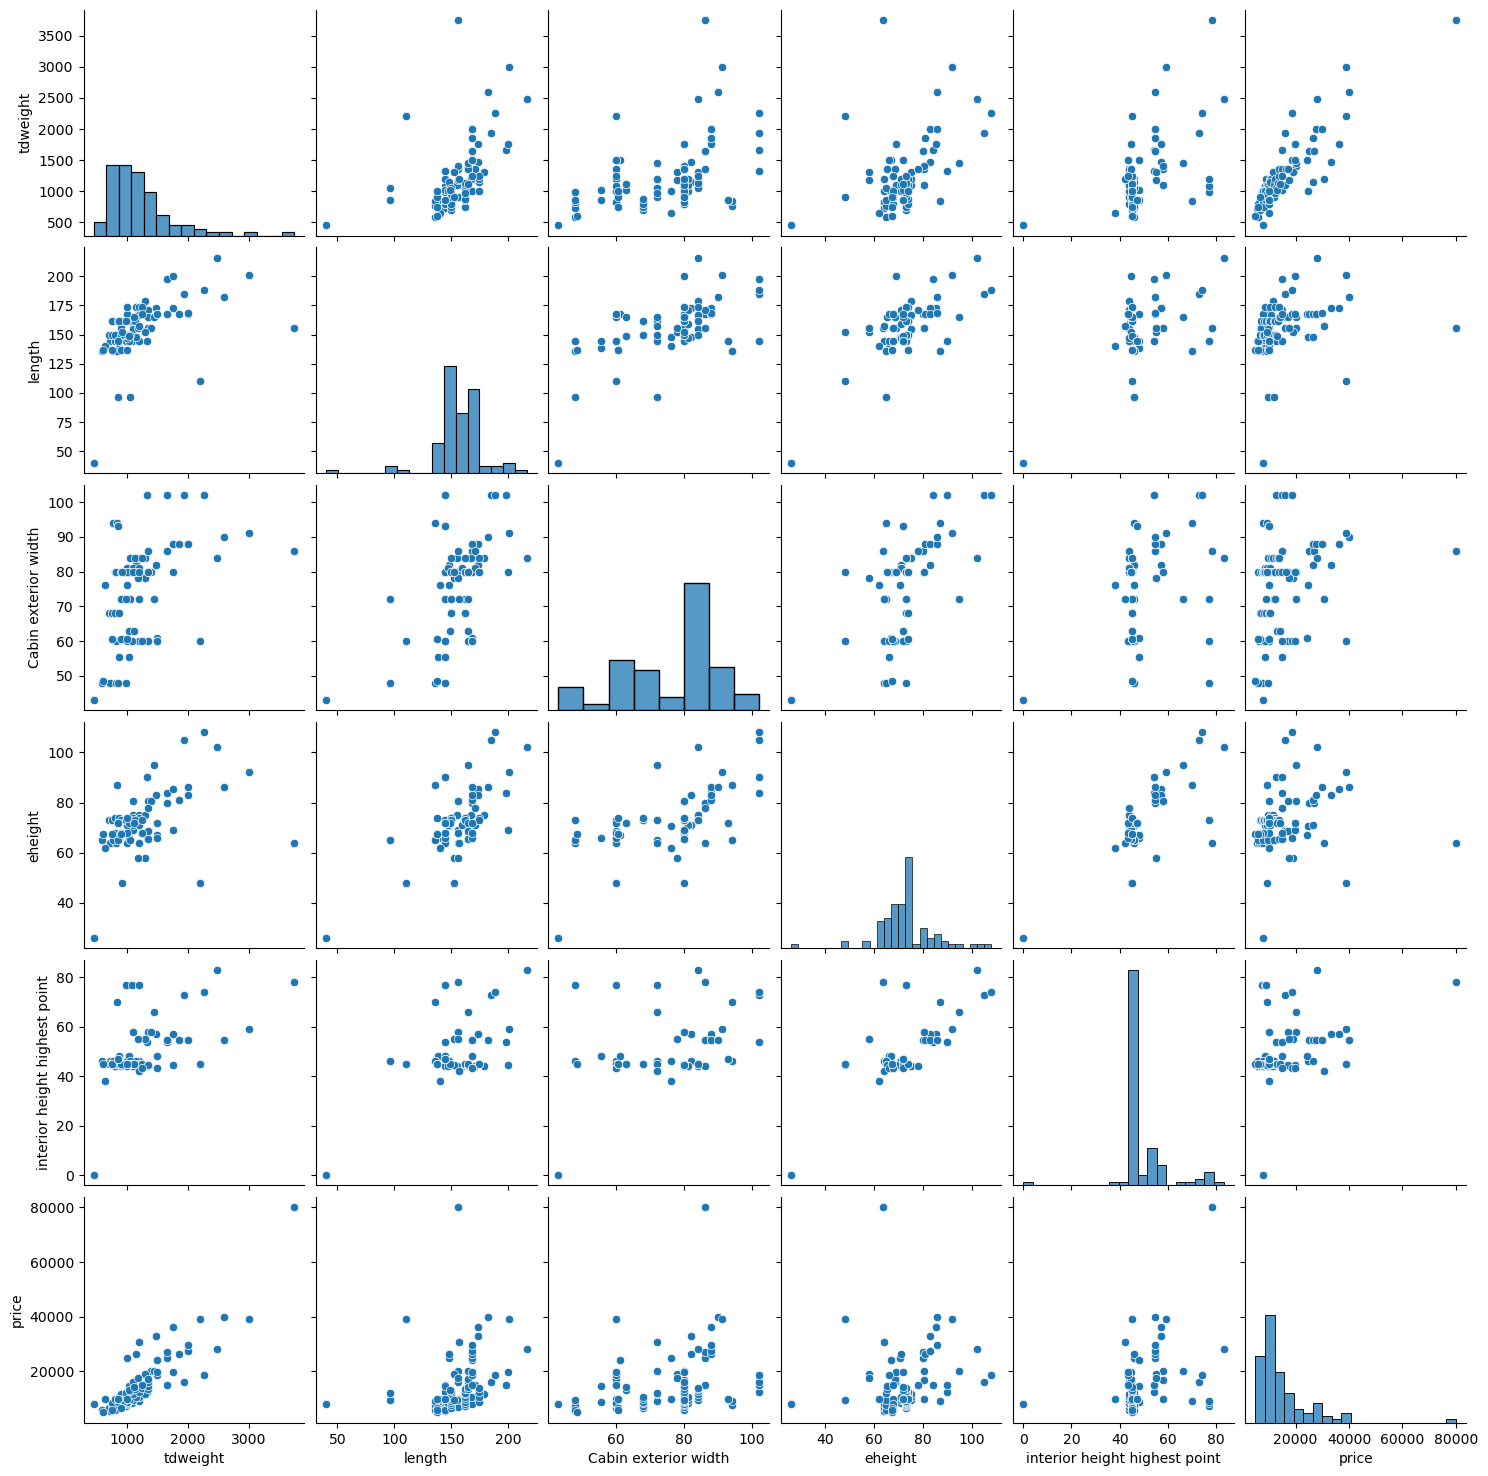

In [10]:
sns.pairplot(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'price']])

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

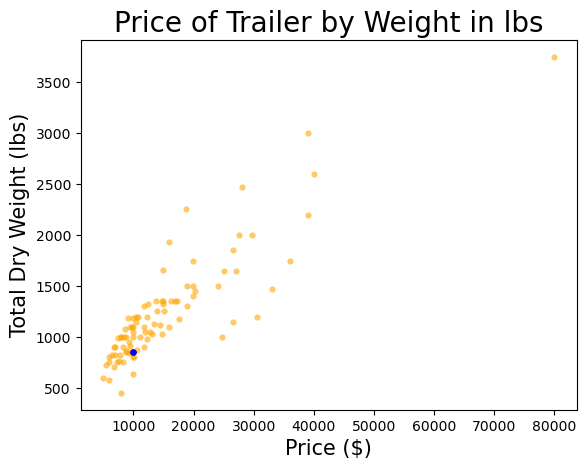

In [11]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

In [12]:
#drop the very expensive heavy trailer outlier
data=data.drop(data.index[76])

Now let's look at how a few features map onto the weight vs. price

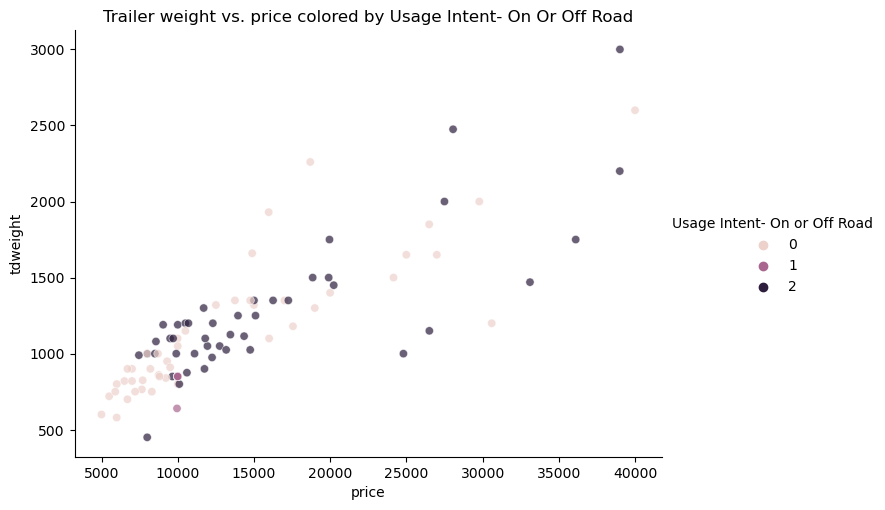

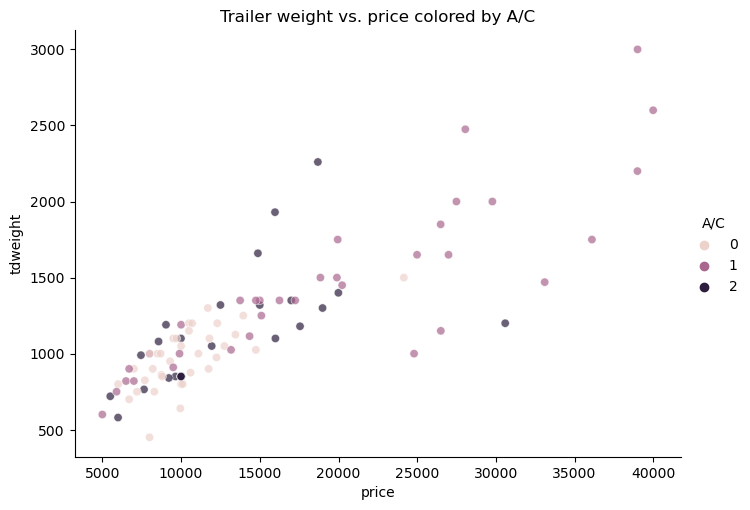

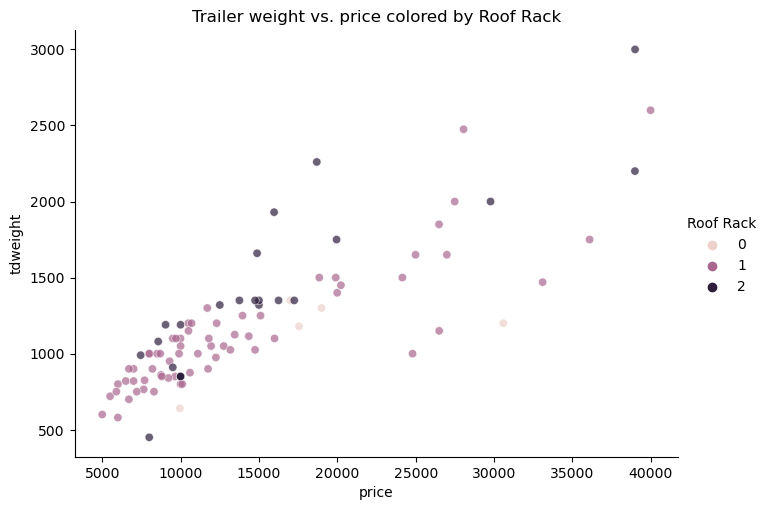

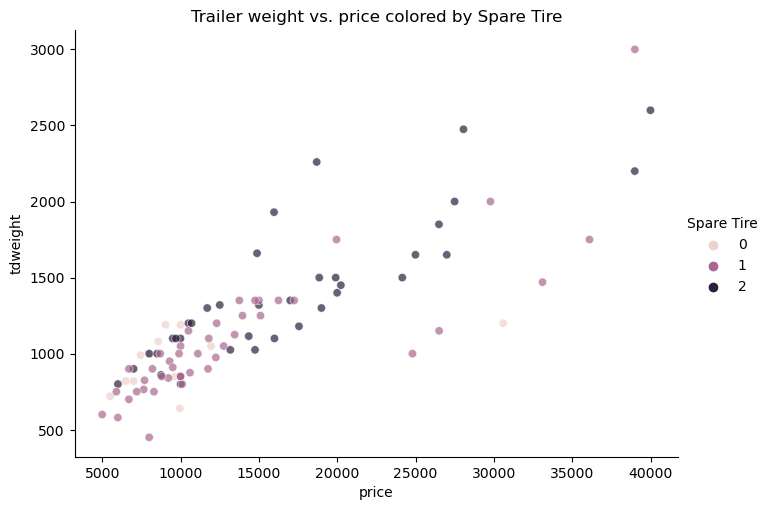

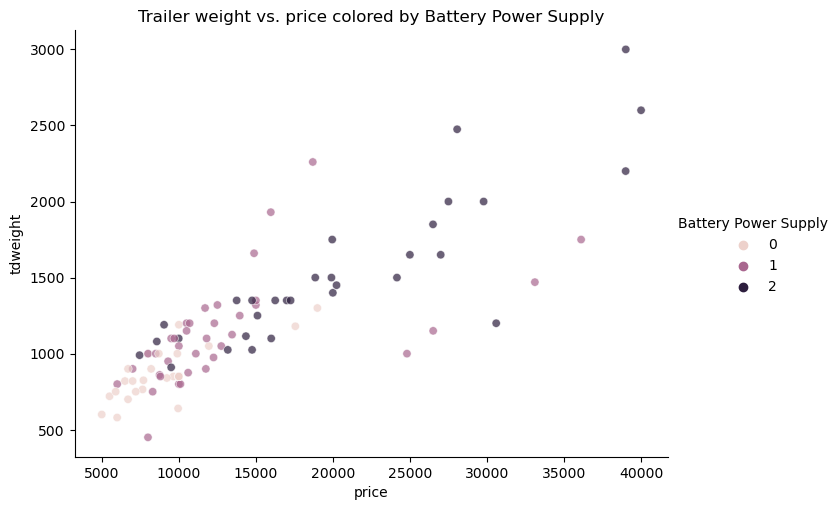

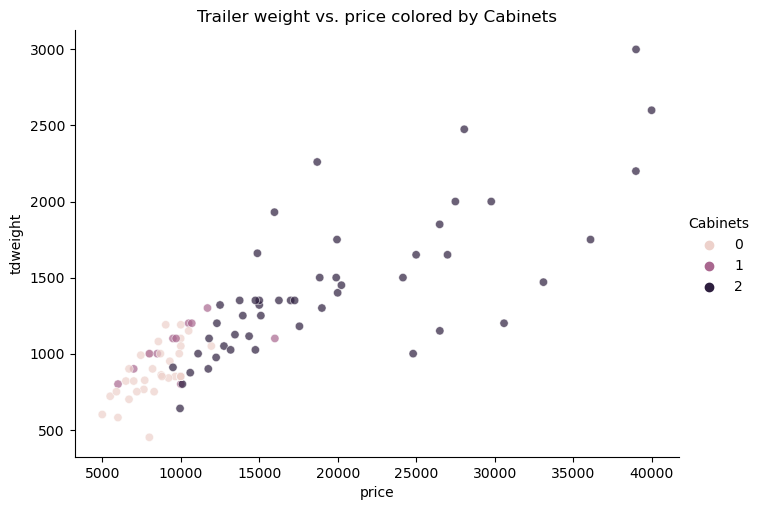

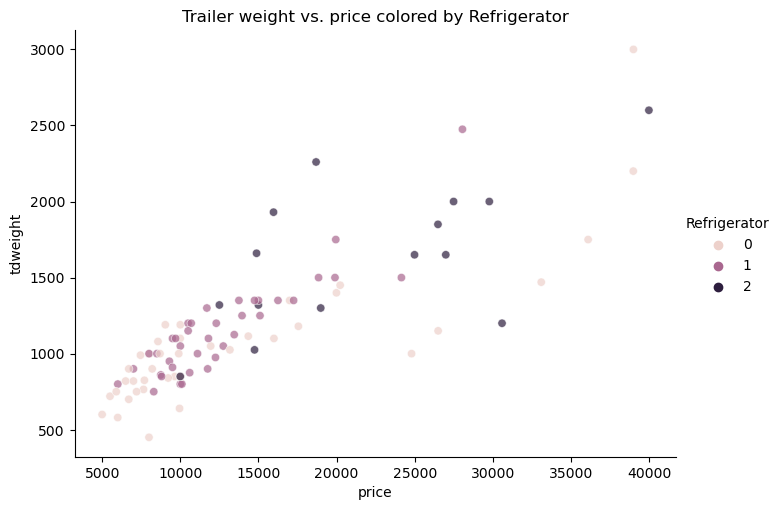

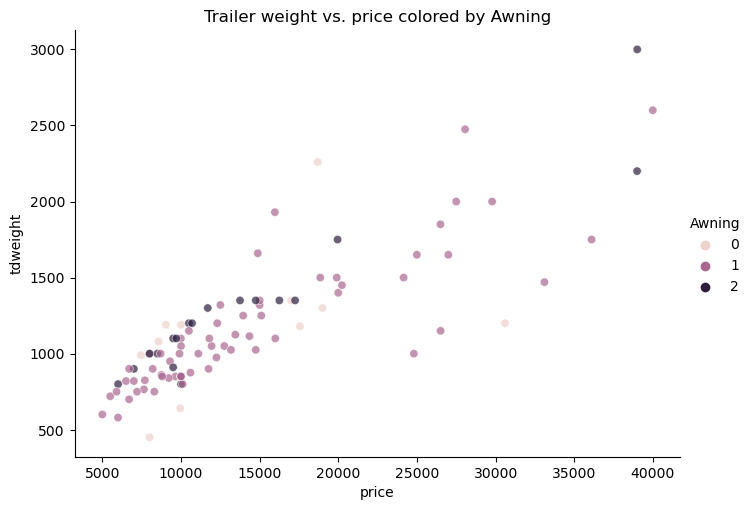

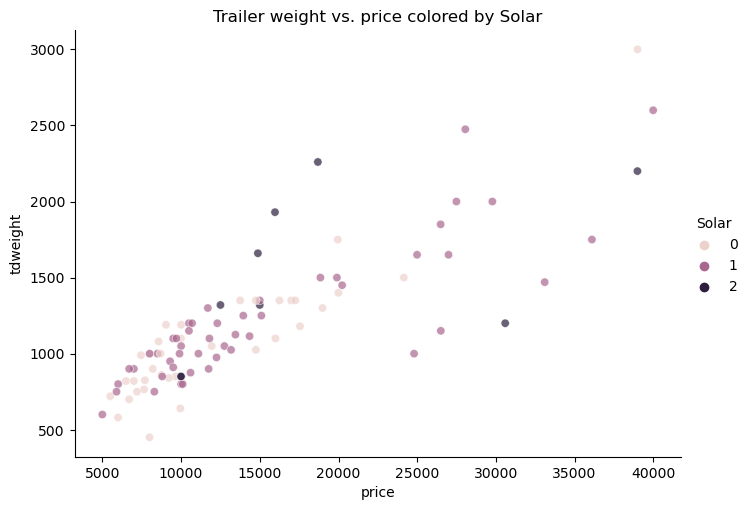

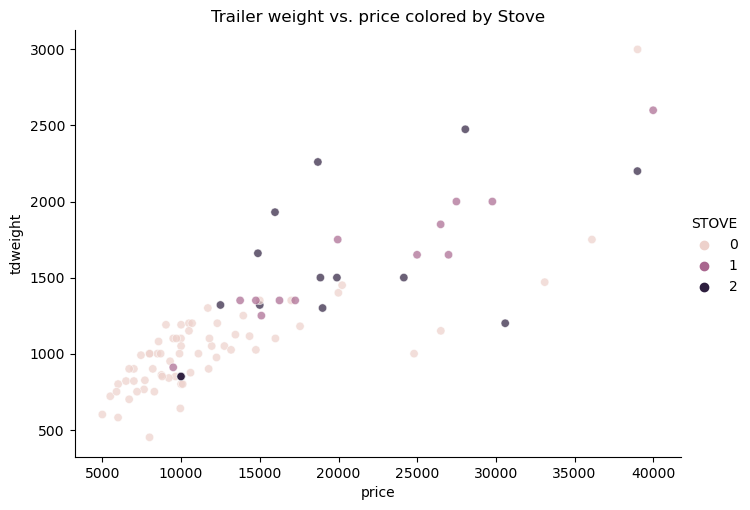

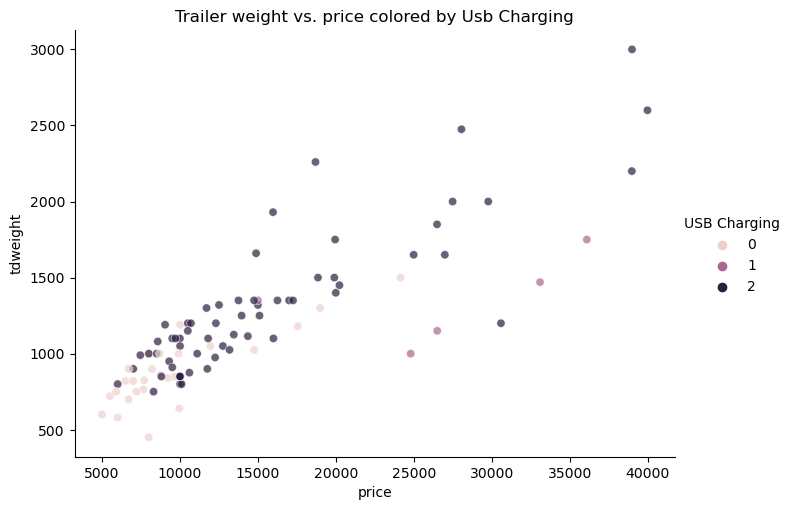

In [13]:
for c in ['Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.7)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [14]:
#These features are highly negatively correlated and contain rather repetitive data
#Relevant columns are added together to reduce complexity
#No:0, Option:1, Yes:2
data["Windows"] = data["Driver Side Window"] + data["Passenger Side Window"]
data["Doors"] = data["Driver Side Door"] + data["Passenger Side Door"]
data["Door Windows"] = data["Driver Side Door Window"] + data["Passenger Side Door Window"]

In [15]:
#reorder the columns so there are no problems with slicing/encoding
data = data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'USB Cost', 'price']]

In [16]:
#checking the columns are reordered
data

,tdweight,length,Cabin exterior width,eheight,interior height highest point,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,1660,198.0,102.0,84.0,54.0,4,2,2,0,2,...,2,1,2,2,1,2,2,2,0,14879
1,1320,144.0,102.0,90.0,54.0,4,2,2,0,2,...,2,1,2,2,1,2,2,2,0,12500
2,1320,144.0,102.0,90.0,54.0,4,2,2,0,2,...,2,1,2,2,1,2,2,2,0,14997
3,1930,185.0,102.0,105.0,73.0,4,2,2,0,2,...,2,1,2,2,1,2,2,2,0,15965
4,2260,188.0,102.0,108.0,74.0,4,2,2,0,2,...,2,1,2,2,0,2,2,2,0,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,850,144.0,93.0,72.0,47.0,2,2,4,1,2,...,1,0,0,0,1,0,0,0,0,9995
92,850,144.0,93.0,72.0,47.0,2,2,4,1,2,...,1,0,0,0,1,0,0,2,0,9995
93,850,144.0,93.0,72.0,47.0,2,2,4,1,2,...,1,0,0,0,1,0,2,2,0,9995
94,850,144.0,93.0,72.0,47.0,2,2,4,1,2,...,1,0,0,0,1,2,2,2,0,9995


In [17]:
#the following section is currently commented out because the data was encoded beforehand 


#select the categorical data for encoding
#cat_data = data.iloc[:, 8:19]
#cat_data

In [18]:
#cat_data = data[['Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging']]
#cat_data

In [19]:
#doesn't help
#created dummy variables from categories (also can use OneHotEncoder)
#all_dummies = pd.get_dummies(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'USB Cost', 'price']])

In [20]:
#from sklearn.preprocessing import LabelEncoder
#labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

#for col in cat_data:
#    data[col] = labelencoder.fit_transform(data[col])
 
#data.head()

In [21]:
#dropping columns which aren't useful 
data = data.drop(['interior height highest point', 'USB Cost'], axis=1)

In [22]:
#make a copy of the data for later
data2=data

In [23]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
tdweight,1.000000,0.600934,0.401825,0.557080,0.098179,0.223258,0.145594,0.116571,0.177787,0.219149,0.378344,0.573902,0.582900,0.407833,0.108412,0.270197,0.484603,0.405653,0.833451
length,0.600934,1.000000,0.470428,0.647860,0.067485,0.343907,0.350038,-0.032622,-0.103124,-0.005800,0.331970,0.376226,0.472748,0.398093,0.228562,0.231897,0.249159,0.449322,0.385321
Cabin exterior width,0.401825,0.470428,1.000000,0.586166,0.034668,-0.070129,0.114030,-0.179074,0.151973,0.205467,0.373460,0.047510,0.306061,0.418946,0.173899,0.385966,0.313807,0.427385,0.274734
eheight,0.557080,0.647860,0.586166,1.000000,0.309861,0.003040,0.019964,-0.052186,0.182041,0.107879,0.304347,0.194558,0.271469,0.315489,-0.023835,0.354072,0.208754,0.361220,0.324345
Windows,0.098179,0.067485,0.034668,0.309861,1.000000,-0.086744,-0.220091,-0.001636,0.147512,-0.167786,0.019463,-0.007949,-0.009875,0.175527,-0.357500,0.036337,-0.118035,0.049601,-0.091999
Doors,0.223258,0.343907,-0.070129,0.003040,-0.086744,1.000000,0.540919,0.182423,-0.417455,-0.219636,-0.161666,0.230171,0.261828,0.149738,0.053961,-0.071280,-0.060331,0.057676,0.297145
Door Windows,0.145594,0.350038,0.114030,0.019964,-0.220091,0.540919,1.000000,-0.026590,-0.313356,-0.066216,-0.003649,0.109232,0.273497,0.215845,0.037804,0.136259,0.176131,0.124391,0.299240
Usage Intent- On or Off Road,0.116571,-0.032622,-0.179074,-0.052186,-0.001636,0.182423,-0.026590,1.000000,-0.178986,0.129640,-0.143189,0.195740,0.259366,-0.140132,0.080913,0.046250,-0.152809,0.198696,0.152897
A/C,0.177787,-0.103124,0.151973,0.182041,0.147512,-0.417455,-0.313356,-0.178986,1.000000,0.276622,-0.114017,-0.010530,-0.066575,-0.120397,-0.370532,-0.057356,0.388992,-0.052966,0.160665
Roof Rack,0.219149,-0.005800,0.205467,0.107879,-0.167786,-0.219636,-0.066216,0.129640,0.276622,1.000000,-0.123230,0.159451,-0.064117,0.075259,0.203898,0.099002,0.321532,0.257370,0.007501


<AxesSubplot:>

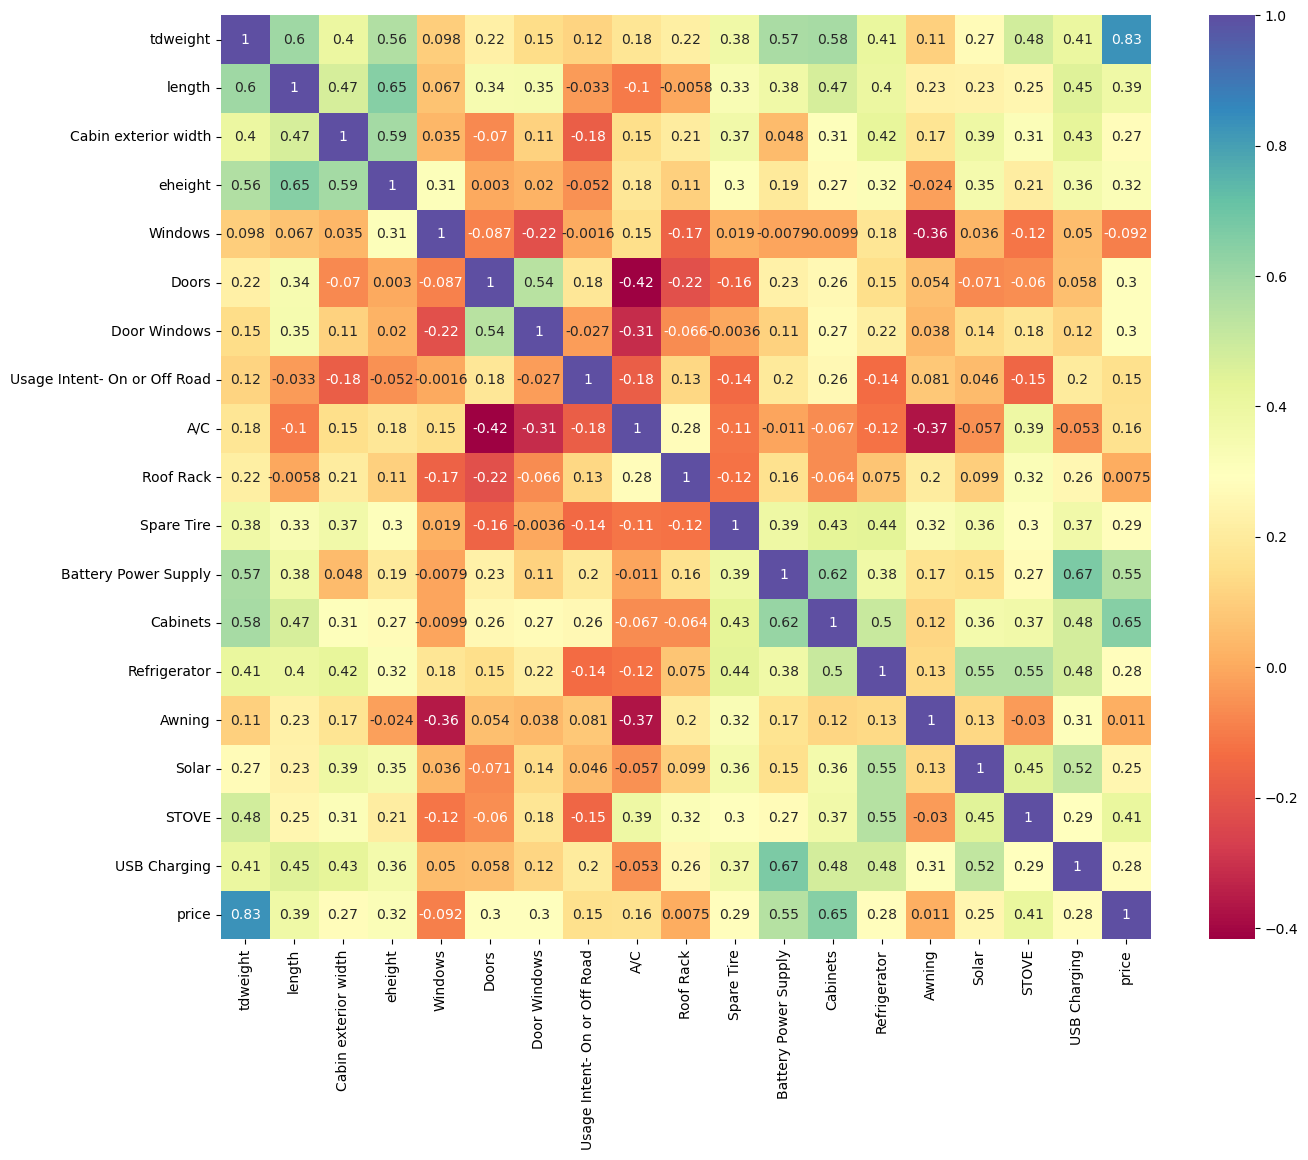

In [24]:
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot=True,cmap="Spectral")

The concept of correlation measures the degree of association between features or the target variable. It can either be positive, which means an increase in the value of one feature results in an increase in the target variable, or negative, where an increase in the value of one feature results in a decrease in the target variable.

By plotting a heatmap of correlated features using the Seaborn library, it becomes easier to determine which features are strongly related to the target variable.

Here we can see that the weight has by far the largest correlation with price, however some luxury features like battery power supply, cabinets and stove also have a high correlation with price. 

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [25]:
data2=data2.drop(data.index[91:])

In [26]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [28]:
#scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    #EVALUATION OF THE MODEL
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    # Plotting y_test and y_pred 
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output common regression metrics: 



*Mean Absolute Error (MAE)* is the mean of the absolute value of the errors

*Mean Squared Error (MSE)* is the mean of the squared errors

*Root Mean Squared Error (RMSE)* is the square root of the mean of the squared errors

**The metrics compared:**

In comparing different metrics, the MAE represents the average error and is the most straightforward to comprehend. Meanwhile, the MSE is more commonly used than MAE as it penalizes larger errors, making it more relevant in real-world scenarios. The RMSE, on the other hand, is more widely used than MSE since it can be interpreted in the same units as the "y" variable. All of these are considered loss functions, as the objective is to minimize their values.

R^2 :  0.8291828059166281
MAE : 2703.542069425732
MSE : 10809753.556575324
RMSE: 3287.8189665149334


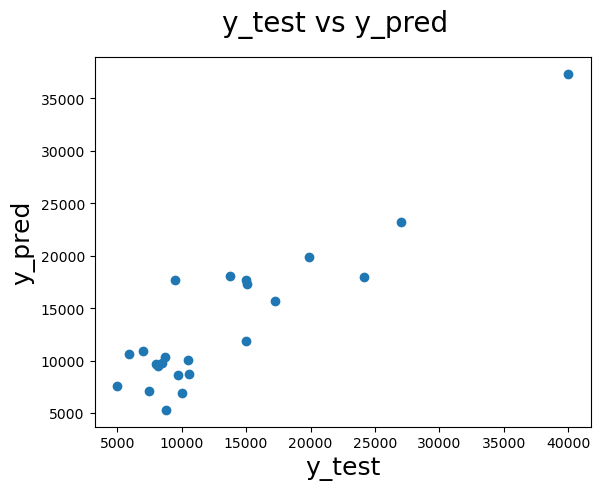

In [30]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.6403874762712343
MAE : 2797.304347826087
MSE : 22757210.0
RMSE: 4770.451760577817


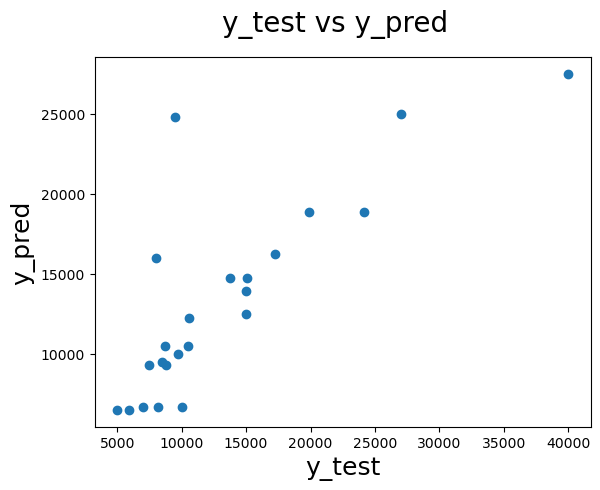

In [31]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.528973126565982
MAE : 4449.720717912398
MSE : 29807798.024482213
RMSE: 5459.651822642376


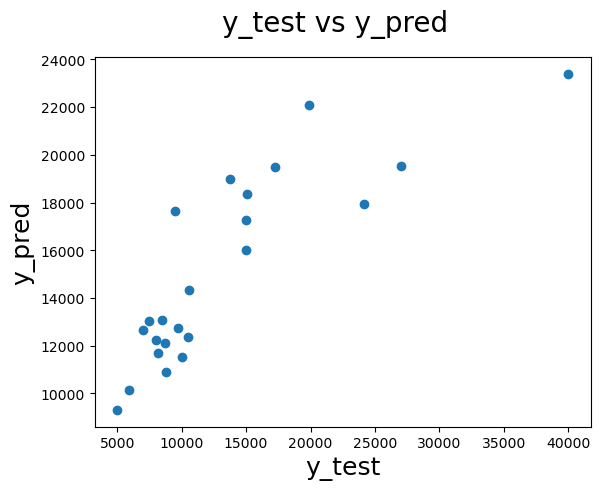

In [32]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7730215519048372
MAE : 2936.136954043921
MSE : 14363782.871676821
RMSE: 3789.958162259423


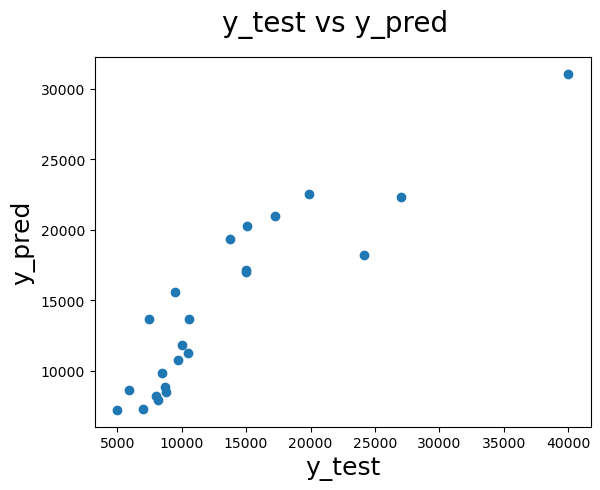

In [33]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.8326240103233562
MAE : 2666.7993142845594
MSE : 10591985.247160425
RMSE: 3254.5330305837156


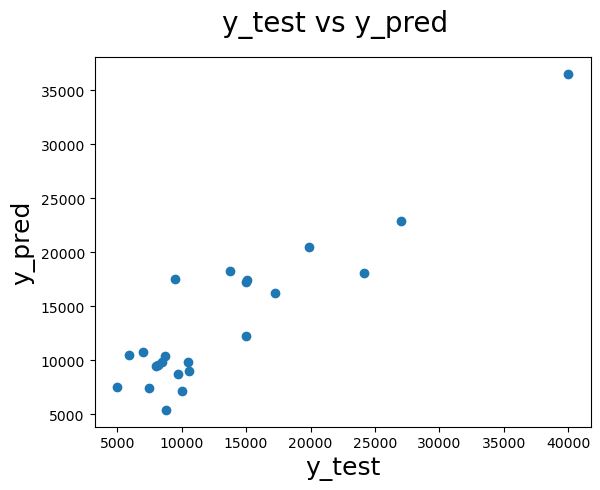

In [34]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.832672672965611
MAE : 2671.2621764750215
MSE : 10588905.749379134
RMSE: 3254.059887183875


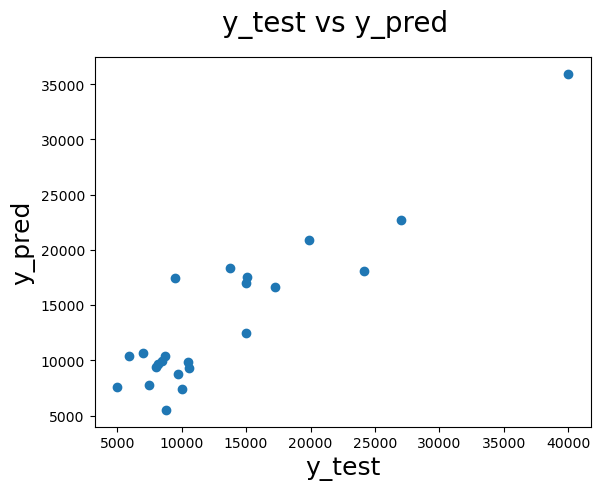

In [35]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.8396621455029836
MAE : 2610.9419128456484
MSE : 10146593.861369941
RMSE: 3185.3718560585576


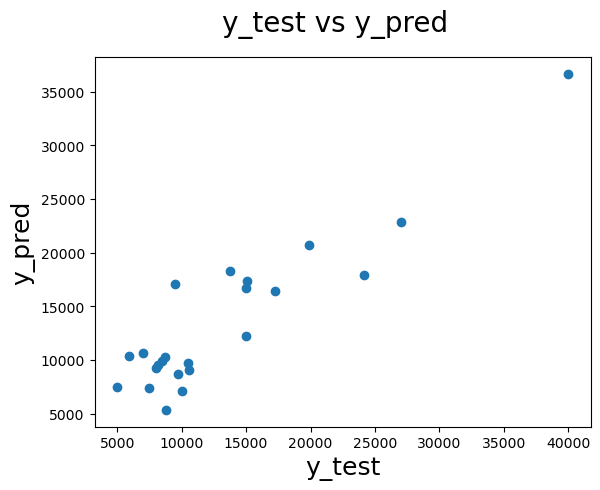

In [36]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.02043020160744735
MAE : 5639.365515140375
MSE : 64575460.68623043
RMSE: 8035.88580594762


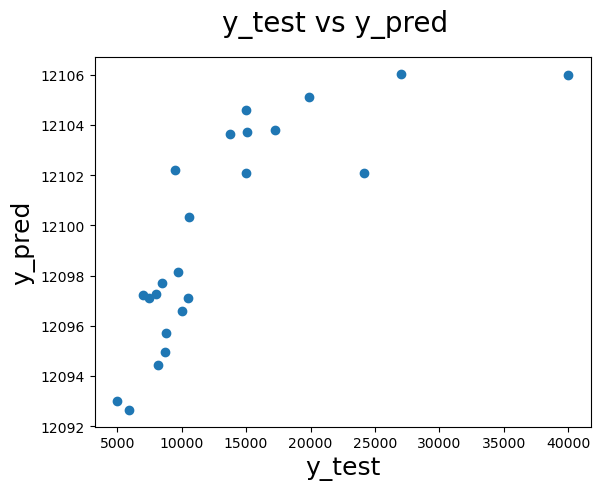

In [37]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7612849630702359
MAE : 2686.3480446606522
MSE : 15106504.548951136
RMSE: 3886.7087038973136


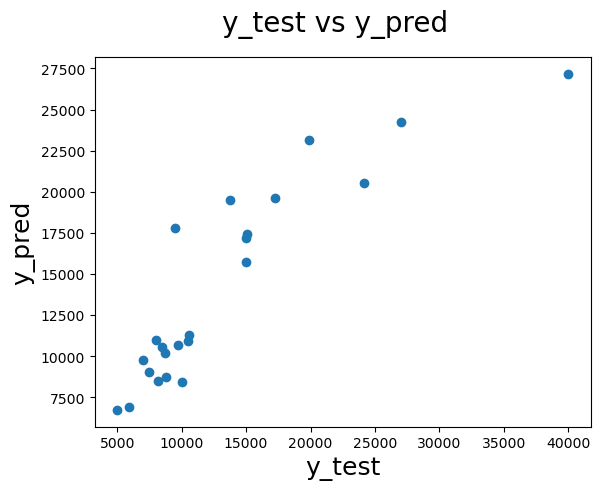

In [38]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance for Feature Engineering

## Chi-squared (χ²) test

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                           Specs         Score
0                       tdweight  15417.741518
1                         length    289.058814
2           Cabin exterior width    212.083784
3                        eheight    154.480481
16                         STOVE    111.797297
4                        Windows     84.563241
7   Usage Intent- On or Off Road     83.911111
12                      Cabinets     62.564220
8                            A/C     61.416667
13                  Refrigerator     60.848485
17                  USB Charging     49.382114
11          Battery Power Supply     47.611111
15                         Solar     46.612903
6                   Door Windows     42.791367
10                    Spare Tire     27.830435
14                        Awning     23.178571
5                          Doors     20.535484
9                      Roof Rack     18.869159


The *chi-squared (χ²) test* is a statistical hypothesis test used to determine the independence of two categorical variables. It is commonly used in machine learning to test the relationship between a feature and a target variable.

The chi-squared test is applicable only to non-negative features and is based on the assumption that the expected frequency of each category should be at least 5. If the expected frequency is less than 5, then the test result may not be reliable.

In the chi-squared test, the observed frequencies of each category are compared to the expected frequencies. The expected frequency of each category is calculated based on the null hypothesis of independence between the feature and the target variable. If the observed frequency significantly deviates from the expected frequency, then the null hypothesis is rejected, indicating that the feature is associated with the target variable.

The chi-squared test outputs a p-value, which represents the probability of observing the test results given that the null hypothesis is true. A small p-value indicates that the feature and target variable are likely associated, while a large p-value suggests that they are independent.

In general, a higher SelectKBest score indicates that the feature is more strongly associated with the target variable, and thus more relevant for the model. Conversely, a lower score indicates that the feature is less important for predicting the target variable.

## Extra Tree Classifier Top 10 Features 

[0.20588254 0.14000933 0.12680881 0.1143475  0.03519606 0.03255337
 0.03166736 0.0444974  0.02982371 0.02933784 0.03148213 0.0278244
 0.03083546 0.02563949 0.02858277 0.02539822 0.02053077 0.01958283]


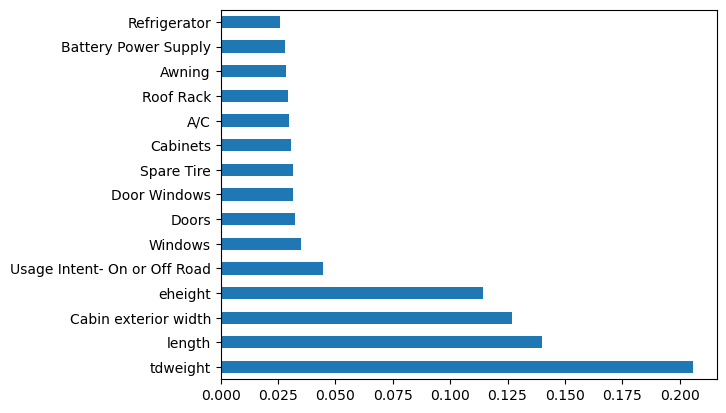

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

To obtain the feature importance of a dataset, one can utilize the feature importance property of the model being used. This property generates a score for each feature, with a higher score indicating greater importance or relevance to the output variable.

The feature importance function is a pre-existing class that is available in Tree-Based Classifiers. In this instance, we will utilize the Extra Tree Classifier to identify the top features of the dataset.

We can see weight is still the most highly correlated to price, followed by other dimensions, On/Off Road and doors/windows. These features are vasty different from the features indicated to be most highly correlated with the price (heatmap).

## Correlation  

In [41]:
#these features have the highest correlation with price
top_corr = data2
corr_matrix = top_corr.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                           1.000000
tdweight                        0.831303
Cabinets                        0.642698
Battery Power Supply            0.542909
STOVE                           0.481617
length                          0.377918
eheight                         0.324890
Door Windows                    0.323397
Cabin exterior width            0.316434
USB Charging                    0.299476
Refrigerator                    0.287338
Spare Tire                      0.279211
Solar                           0.278790
Doors                           0.277636
A/C                             0.202996
Usage Intent- On or Off Road    0.154134
Roof Rack                       0.045913
Awning                          0.007989
Windows                        -0.103608
Name: price, dtype: float64


# Regressive Feature Selection
Recursive feature elimination is an example of backward feature elimination in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features, which is set by the parameter n_features_to_select

In [42]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

# perform a scikit-learn Recursive Feature Elimination (RFE)

#we want only one final feature to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# print out features in order of ranking
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

# choose top 10 featues and use them for the model
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# use the model to predict the prices for the test data
predictions = rfe.predict(X_test)

1 tdweight
2 Cabinets
3 A/C
4 Refrigerator
5 Windows
6 Cabin exterior width
7 length
8 eheight
9 Doors
10 Solar
11 Spare Tire
12 Door Windows
13 STOVE
14 Roof Rack
15 Battery Power Supply
16 USB Charging
17 Awning
18 Usage Intent- On or Off Road


# Feature Engineering
This section is in progress while more feature data is collected.

In [43]:
#the last columns contain values we want to predict
data3=data.drop(data.index[91:])

In [44]:
#removing features which preformed worst in numerous tests 
X = data3.drop(['price', 'Awning', 'Roof Rack'],axis=1)
y=data3['price']

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [46]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

R^2 :  0.7338062343908085
MAE : 3140.8136391954404
MSE : 16845429.524663076
RMSE: 4104.318399523005


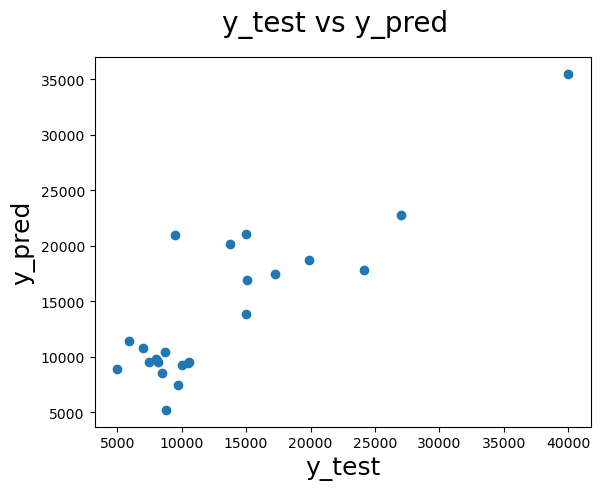

In [48]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.6402568688703303
MAE : 2781.608695652174
MSE : 22765475.173913043
RMSE: 4771.317970321517


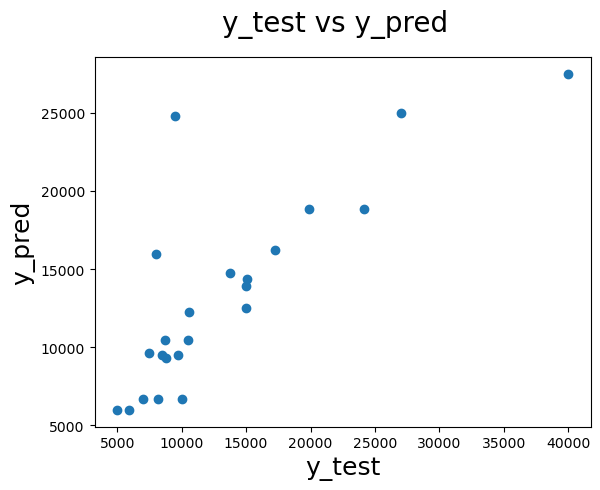

In [49]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5158825231949098
MAE : 4533.781279550264
MSE : 30636205.241375733
RMSE: 5534.998215119472


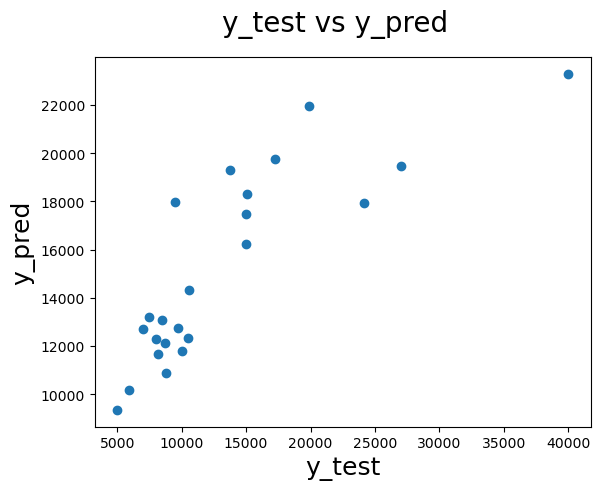

In [50]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7774720828456013
MAE : 2895.100932567223
MSE : 14082141.77035951
RMSE: 3752.617988865841


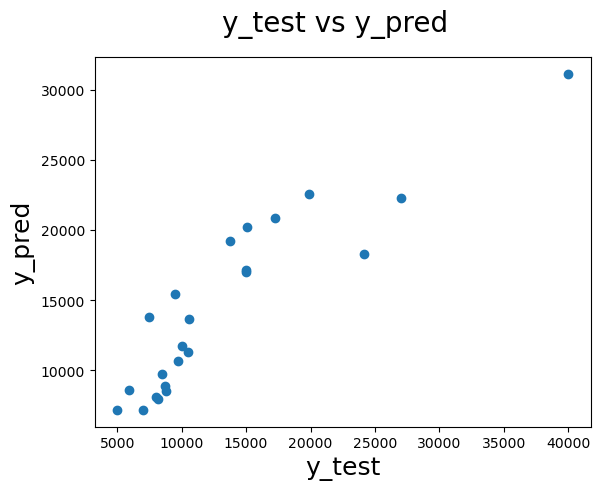

In [51]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7404399161949355
MAE : 3099.863228464638
MSE : 16425632.993873836
RMSE: 4052.854918927377


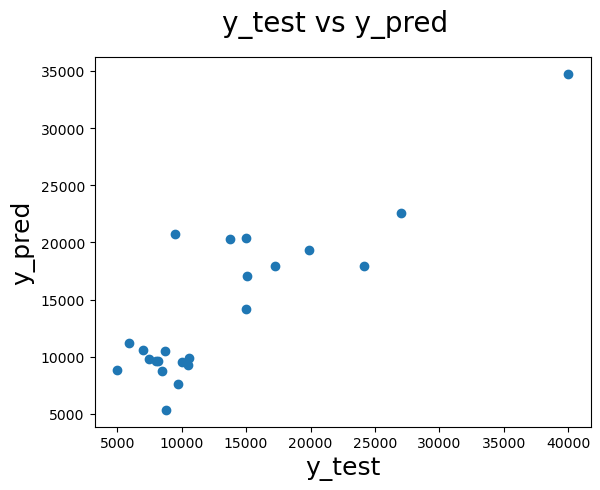

In [52]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7430454085758523
MAE : 3074.8685152842327
MSE : 16260750.701535637
RMSE: 4032.462114085591


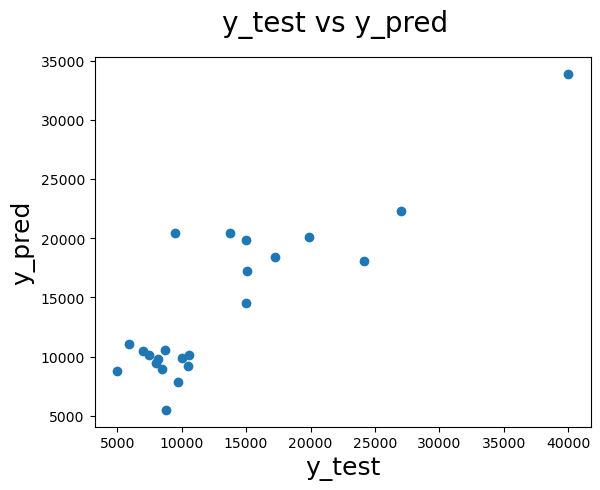

In [53]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7513167456043188
MAE : 3019.4402789107785
MSE : 15737319.115266517
RMSE: 3967.029003582721


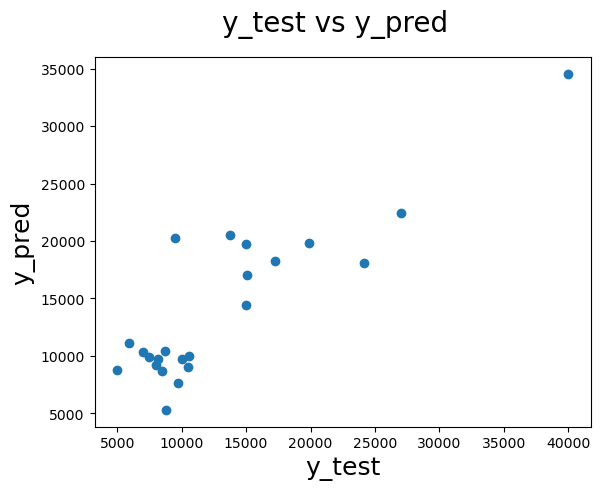

In [54]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.020396652920994685
MAE : 5639.28122676741
MSE : 64573337.63863767
RMSE: 8035.753706942347


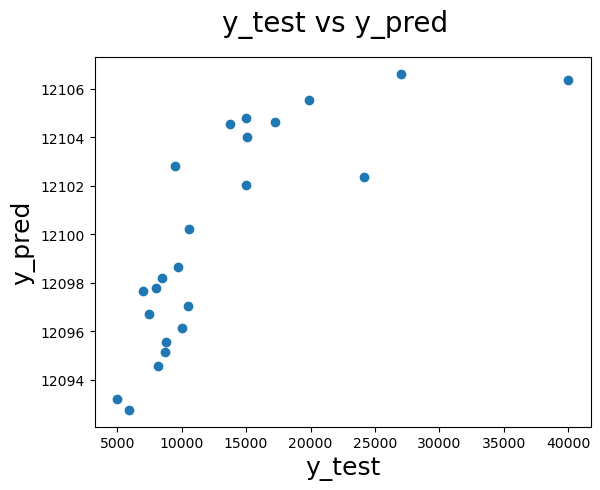

In [55]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7502489016475045
MAE : 2759.954391922086
MSE : 15804895.040933622
RMSE: 3975.5370757840533


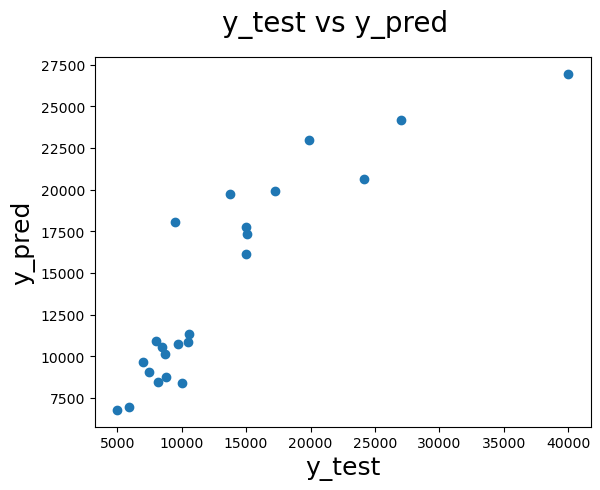

In [56]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.22855092 0.15609965 0.12333274 0.12104885 0.03561889 0.0340234
 0.03449169 0.04515509 0.03173659 0.03204247 0.0334934  0.02961113
 0.02510778 0.02710301 0.02217554 0.02040886]


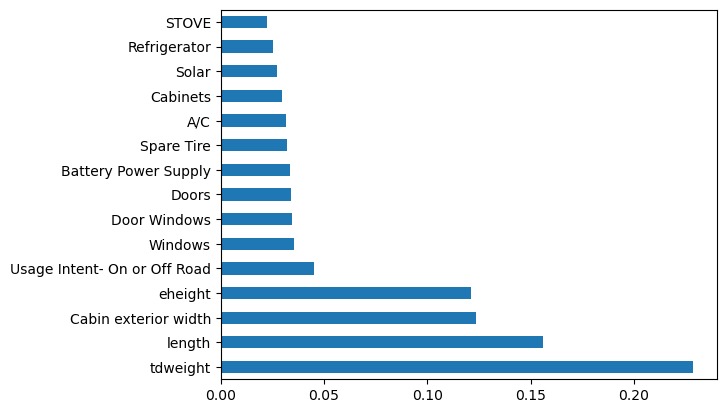

In [57]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [58]:
rfc=RandomForestRegressor(random_state=1)

In [59]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [60]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 500, 1000, 5000]})

In [61]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 15, 'n_estimators': 500}

R^2 :  0.7908724325701277
MAE : 2465.178009661836
MSE : 13234133.003611172
RMSE: 3637.874792184466


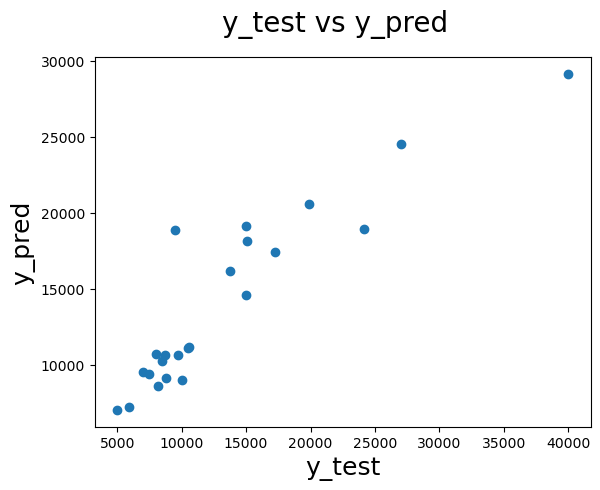

In [62]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=500, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [64]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

R^2 :  0.9768457566535256
MAE : 784.567020274171
MSE : 1035149.7184008561
RMSE: 1017.4230773876009


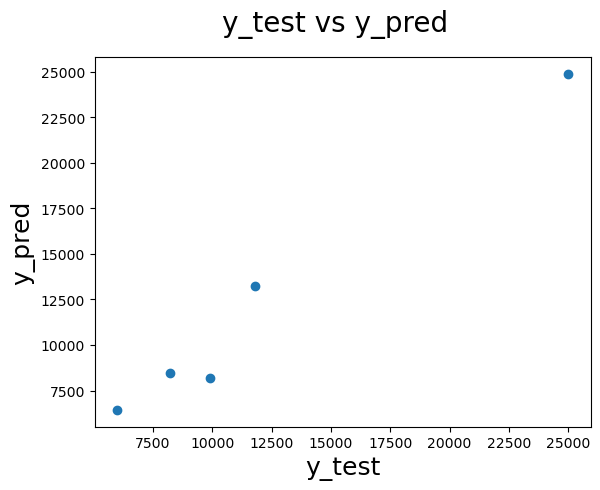

In [65]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

In [66]:
new_input = data.loc[91:]
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
91,850,144.0,93.0,72.0,2,2,4,1,2,2,1,0,0,0,1,0,0,0,9995
92,850,144.0,93.0,72.0,2,2,4,1,2,2,1,0,0,0,1,0,0,2,9995
93,850,144.0,93.0,72.0,2,2,4,1,2,2,1,0,0,0,1,0,2,2,9995
94,850,144.0,93.0,72.0,2,2,4,1,2,2,1,0,0,0,1,2,2,2,9995
95,850,144.0,93.0,72.0,2,2,4,1,2,2,1,0,0,2,1,2,2,2,9995


In [67]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Awning', 'Roof Rack'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Solar,STOVE,USB Charging
91,850,144.0,93.0,72.0,2,2,4,1,2,1,0,0,0,0,0,0
92,850,144.0,93.0,72.0,2,2,4,1,2,1,0,0,0,0,0,2
93,850,144.0,93.0,72.0,2,2,4,1,2,1,0,0,0,0,2,2
94,850,144.0,93.0,72.0,2,2,4,1,2,1,0,0,0,2,2,2
95,850,144.0,93.0,72.0,2,2,4,1,2,1,0,0,2,2,2,2


In [68]:
new_input_scaled = scaler.fit_transform(new_input)

In [69]:
#CV?
new_output = final_model.predict(new_input_scaled)
new_output

array([12650.696     , 12639.94133333, 13843.51533333, 14080.12333333,
       13841.31666667])

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>